In [4]:
%pip install keras

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [1]:
from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

(train_ds, test_ds) = tfds.load(
    'deep_weeds',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
)

2021-10-17 16:45:16.081814: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_ds_numpy = [(instance.numpy(), label.numpy()) for instance, label in train_ds if label < 8]
test_ds_numpy = [(instance.numpy(), label.numpy()) for instance, label in test_ds if label < 8]

random_train_indices = np.random.choice(len(train_ds_numpy), size=500, replace=False)
random_test_indices = np.random.choice(len(test_ds_numpy), size=125, replace=False)

X_train_original = [[instance for instance, _ in train_ds_numpy][i] for i in random_train_indices]
y_train = [[label for _, label in train_ds_numpy][i] for i in random_train_indices]

X_test_original = [[instance for instance, _ in test_ds_numpy][i] for i in random_test_indices]
y_test = [[label for _, label in test_ds_numpy][i] for i in random_test_indices]

print(len(X_train_original))
print(len(X_test_original))

2021-10-17 16:45:16.173681: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


500
125


In [ ]:
# from skimage import feature
# import cv2

# print(np.array(X_test_original).shape)

# sigma = 1.5
# X_train_image = list(map(lambda x: feature.canny(cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), sigma=sigma), X_train_original))
# X_test_image = list(map(lambda x: feature.canny(cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), sigma=sigma), X_test_original))

(125, 256, 256, 3)


Text(0.5, 1.0, 'from X_test with $\\sigma=1.5$')

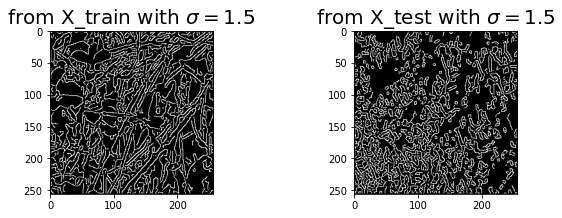

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# ax[0].imshow(X_train_image[0], cmap='gray')
# ax[0].set_title(r'from X_train with $\sigma=1.5$', fontsize=20)

# ax[1].imshow(X_test_image[0], cmap='gray')
# ax[1].set_title(r'from X_test with $\sigma=1.5$', fontsize=20)

In [8]:
# Instantiate convolutional base
# Reference: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751
from tensorflow.keras.applications import VGG16

img_width, img_height = X_train_original[0].shape[0:2]
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

conv_base.summary()

58900480/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [15]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(x, y):
    sample_count = len(y)
    
    features = np.zeros(shape=(sample_count, 8, 8, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow(np.array(x), np.array(y), batch_size = batch_size)
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        print(features_batch.shape)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(X_train_original, y_train)  # Agree with our small dataset size
# validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(X_test_original, y_test)

(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(20, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(32, 8, 8, 512)
(29, 8, 8, 512)


In [29]:
X_train = list(map(lambda x: x.flatten(), train_features))
y_train = train_labels
X_test = list(map(lambda x: x.flatten(), test_features))
y_test = test_labels

print(train_labels.shape)
print("feature size now:", X_train[0].shape) # orginal feature is of dimension 196608

(500,)
feature size now: (32768,)


In [30]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
linear_pred = linear.predict(X_test)
accuracy_lin = linear.score(X_test, y_test)
print("Accuracy Linear Kernel:", accuracy_lin)

Accuracy Linear Kernel: 0.672


In [31]:
rbf = svm.SVC(kernel='rbf', gamma=0.1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
rbf_pred = rbf.predict(X_test)
accuracy_rbf = rbf.score(X_test, y_test)
print("Accuracy Radial Basis Kernel:", accuracy_rbf)

Accuracy Radial Basis Kernel: 0.104


In [32]:
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly_pred = poly.predict(X_test)
accuracy_poly = poly.score(X_test, y_test)
print("Accuracy Polynomial Kernel:", accuracy_poly)

Accuracy Polynomial Kernel: 0.472


In [33]:
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)
sig_pred = sig.predict(X_test)
accuracy_sig = sig.score(X_test, y_test)
print("Accuracy Sigmoid Kernel:", accuracy_sig)

Accuracy Sigmoid Kernel: 0.176
